In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import os
import shutil
import mne
import warnings
import random

from data_extraction import  Extract_data_from_subject, Extract_data_multisubject
from data_processing import  Select_time_window, Transform_for_classificator, Split_trial_in_time
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score

tf.keras.utils.set_random_seed(123)
tf.config.run_functions_eagerly(True)
# tf.data.experimental.enable_debug_mode()

mne.set_log_level(verbose='warning') #to avoid info at terminal
warnings.filterwarnings(action = "ignore", category = DeprecationWarning ) 
warnings.filterwarnings(action = "ignore", category = FutureWarning ) 
warnings.filterwarnings(action = 'ignore', category = UserWarning)

# Notes on Data Extraction:

### Parameters
> - Sampling Rate (fs) = 256
> - data type: eeg, exg or baseline
> - T-start: start of window (t=0: focus, t=0.5: arrow, t=1: cue (thinking), t=3.5: rest t=4.5: end)
> - T-end: close of window
> - N_S: subject number (1 through 10)
> - N_B: Session (batch) number

### Extract_subject_from_BDF(root_dir,N_S,N_B):

> Loads raw data for subject and session. Takes the directory pointing to folder containing all recordings
> and preprocessed files, subject number and session/batch number, and returns (raw data, subject number)

### Extract_data_from_subject(root_dir,N_S,datatype):

> Loads all blocks for one subject and stacks results. Takes the directory, calls the file for specified data 
> under the specified subject, and stacks all samples into one object. Also calls the labels. Returns (X,Y): 
> object with stacked trials/samples, and object with correlated labels.

### Extract_block_data_from_subject(root_dir,N_S,datatype,N_B):

> Does the same as above Extract_data_from_subject, but for a specified N_B (batch or session number).
> returns (data samples, labels)

### Extract_report(root_dir,N_B,N_S):

> Pulls report with information regarding the given subject and session. Includes subject age, gender,
> length of recording, count of correct and incorrect answer to control questions, position of contaminated
> trials, mean power for EXG channels 7 & 8, and mean and STD for EXG 7 & 8 baseline recordings.

### Extract_TFR(TRF_dir, Cond, Class, TFR_method , TRF_type):

> Returns Time-Frequency Representation of specified condition and class. 
>
> *Note: location of TRF data unclear, not likely to use in scope of project.*

### Extract_data_multisubject(root_dir, N_S_list, datatype='EEG'):

> Creates a stacked object of all sessions for all listed subjects and returns the stacked trials/samples
> along with a stack of the corresponding labels.

### load_events(root_dir,N_S,N_B):

> Loads the events file to gather the label(s) for dataset using root directory, subject, and batch number.

### Select_time_window(X,t_start=1, t_end=2.5, fs=256):

> Cuts samples to desired time window.

### Transform_for_classificator (X, Y, Classes, Conditions):

> Pulls from the extracted dataset the trials and labels that correspond to the conditions and classes that
> will be used for training and/or testing.


In [2]:
root_dir = '/kaggle/input/inner-speech-recognition/inner-speech-recognition'

A few key factors in the data:

- The sampling rate is 256 Hz
- The initial time of arrow appearance is t = 0.5s
- The thought trial begins at t = 1s when the focus point appears
- The thought trial ends at t = 3.5s when the blue relax point appears
- recording ends at t = 4.5s

To begin, we will look at EEG data for subject 2 from t = 1.5 to 3.5s.

In [3]:
N_S = 2
datatype = 'eeg'
Tstart = 1.5
Tend = 3.5
fs = 256

samples2, labels2 = Extract_data_from_subject(root_dir,N_S,datatype)

In [4]:
Subj2 = Select_time_window(X = samples2, t_start = Tstart, t_end = Tend, fs = fs)

In [5]:
Subj2_inner, labels2_inner = Transform_for_classificator(X = Subj2, Y = labels2, Classes = [['ALL']], Conditions = [['Inner']])

In [6]:
input_shape = (Subj2_inner.shape[1],Subj2_inner.shape[2],1)
print(input_shape)

(128, 512, 1)


Now that we have our data imported, windows sliced and classes and conditions picked, we need to do some final adjustments such as one-hot encoding.

In [7]:
# Labels_2_inner[:,(0,1)].shape
# print(Labels_2_inner[:,(0,1)])
labels = labels2_inner[:,1]
#labels_ = pd.get_dummies(labels) for 1 hot-encoded options

In [8]:
X = Subj2_inner
y = labels

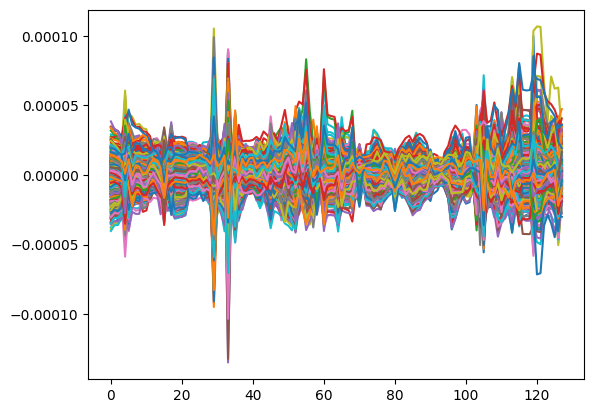

In [9]:
plt.plot(Subj2_inner[1,:,:]);

Looking at the data, we can see that the magnitude of the signal is very small. This may cause problems if our biases and weights are too large relative to our input data. For expediency, we will multiply the data values by a constant rather than create a normalization pipeline.

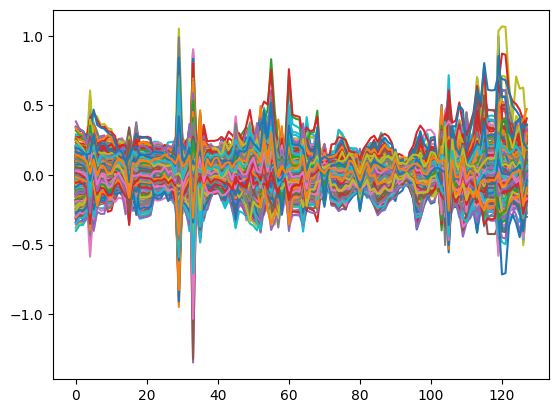

In [10]:
X = X * (10**4)
plt.plot(X[1,:,:]);

# Building our Model

Now that we have seen our data, we will build our CNN to train and fit onto our EEG data

In [11]:
# split data into train and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.125)

In [12]:
print(X_train.shape)
print(X_test.shape)

(210, 128, 512)
(30, 128, 512)


In [13]:
Adam_ = tf.keras.optimizers.Adam(learning_rate=0.001, weight_decay=0.0005)
# L1_ = tf.keras.regularizers.L1(l1=0.0005)

def create_cnn(input_shape):
    # create model - Sequential class, linear stack of layers can be added
    model = models.Sequential()
    # first layer
    model.add(layers.Conv2D(48, kernel_size = (1,13), padding = 'valid', activation='relu', input_shape= input_shape, strides = (1,2)))
    # adds max pooling layer
    model.add(layers.MaxPooling2D(pool_size=(1, 2)))
    # second layer
    model.add(layers.Conv2D(32, kernel_size = (1,7), padding = 'valid', activation='relu'))
    # adds max pooling layer
    model.add(layers.MaxPooling2D(pool_size=(2, 2)))
    # flatten output before last convolutional layer
    model.add(layers.Flatten())
    # Add a fully connected layer 
    model.add(layers.Dense(2000, activation='relu')) 
    
#,kernel_regularizer = L1_, bias_regularizer = L1_ removed for testing

    # Add Dropout for regularization
    model.add(layers.Dropout(0.5)) # 0.2 is the default
    # Output layer 
    model.add(layers.Dense(4, activation='softmax'))

    # Compile model
    model.compile( 
        optimizer = Adam_, # default
        loss = 'sparse_categorical_crossentropy',
        metrics = ['accuracy'],
        )    
    
    return model

cnn = create_cnn(input_shape)

cnn.summary()       

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 250, 48)      672       
                                                                 
 max_pooling2d (MaxPooling2  (None, 128, 125, 48)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 119, 32)      10784     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 64, 59, 32)        0         
 g2D)                                                            
                                                                 
 flatten (Flatten)           (None, 120832)            0         
                                                                 
 dense (Dense)               (None, 2000)              2

In [14]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  0


In [15]:
#build stratified kfold for Cross-Validation
k_fold = StratifiedKFold(n_splits=5, shuffle=True)
train_fold = []
val_fold = []
for train_ind, val_ind in k_fold.split(X_train,y_train):
    train_fold.append(train_ind)
    val_fold.append(val_ind)

In [16]:
np.shape(val_fold)

(5, 42)

In [17]:
class CVGen(tf.keras.utils.Sequence):
    
    def __init__(self, x_train, y_train, batch_size, fold_key):
        
        self.x = x_train
        self.y = y_train
        self.batch_size = batch_size
        self.fold = fold_key
        self.epochh = 0
    
    def on_epoch_begin(self):
            self.epochh += 1
    
    def __getitem__(self, index):
        j = self.epochh % 5;
        low = index * self.batch_size
        high = min(low + self.batch_size, len(self.x))
        batch_X = self.x[self.fold [j] [low : high]]
        batch_Y = self.y[self.fold [j] [low : high]]
        return np.array(batch_X), np.array(batch_Y)
    
    def __len__(self):
        return len(self.x) // self.batch_size

In [18]:
# Train model
EarlyStop = tf.keras.callbacks.EarlyStopping(monitor="val_loss", min_delta = 0.000001, patience = 3, start_from_epoch = 5, verbose=1)
ReduceLR = tf.keras.callbacks.ReduceLROnPlateau(monitor="loss", factor = 0.1, patience = 3, cooldown = 3, verbose = 1, min_delta = 0.000001, min_lr = 0.0001)
BATCH_SIZE = 21

history = cnn.fit(
    CVGen(X_train, y_train, batch_size = BATCH_SIZE, fold_key = train_fold),
    epochs=5,
    verbose= 1, # display progress bar with the training loss and metrics
    callbacks = [EarlyStop, ReduceLR],
    validation_data = CVGen(X_train, y_train, batch_size = BATCH_SIZE, fold_key = val_fold)
)


Epoch 1/5
10/10 [==============================] - 69s 7s/step - loss: 3.4572 - accuracy: 0.2321 - val_loss: 1.4308 - val_accuracy: 0.2857 - lr: 0.0010
Epoch 2/5
10/10 [==============================] - 66s 7s/step - loss: 1.3694 - accuracy: 0.2857 - val_loss: 1.3863 - val_accuracy: 0.1905 - lr: 0.0010
Epoch 3/5
10/10 [==============================] - 68s 7s/step - loss: 1.3853 - accuracy: 0.2619 - val_loss: 1.3858 - val_accuracy: 0.2857 - lr: 0.0010
Epoch 4/5
10/10 [==============================] - 67s 7s/step - loss: 1.3855 - accuracy: 0.2857 - val_loss: 1.3856 - val_accuracy: 0.2857 - lr: 0.0010
Epoch 5/5
10/10 [==============================] - ETA: 0s - loss: 1.3858 - accuracy: 0.2738
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
10/10 [==============================] - 67s 7s/step - loss: 1.3858 - accuracy: 0.2738 - val_loss: 1.3854 - val_accuracy: 0.2857 - lr: 0.0010


In [19]:
#predict model
y_pred = cnn.predict(
    X_test,
    verbose = 1
)

1/1 [==============================] - 1s 782ms/step


In [20]:
print(y_pred)

[[0.25558022 0.24393754 0.2506634  0.24981885]
 [0.25557736 0.2439283  0.2506699  0.24982455]
 [0.25559178 0.24392995 0.25067434 0.24980395]
 [0.25560367 0.24389955 0.2506909  0.24980581]
 [0.25573784 0.24364632 0.25076285 0.24985299]
 [0.2555877  0.2439252  0.25068566 0.24980144]
 [0.25562474 0.24381207 0.25074923 0.24981394]
 [0.25558978 0.24391754 0.25069615 0.24979648]
 [0.25561404 0.24391238 0.25067452 0.24979898]
 [0.25570968 0.24382353 0.25066438 0.24980246]
 [0.25567135 0.24368653 0.25075978 0.2498822 ]
 [0.25569132 0.24372837 0.25080165 0.24977854]
 [0.25562635 0.24386846 0.25069448 0.24981067]
 [0.25559887 0.24389444 0.25069177 0.24981502]
 [0.2555877  0.2439252  0.25068566 0.24980144]
 [0.25555226 0.24383454 0.25080314 0.24981005]
 [0.25576222 0.24380955 0.250646   0.24978219]
 [0.25560752 0.24391833 0.25066498 0.24980912]
 [0.25568855 0.24381591 0.25062114 0.24987432]
 [0.25560558 0.24391402 0.25065666 0.24982361]
 [0.25562912 0.24389857 0.25065002 0.24982232]
 [0.25582594 

In [21]:
# evaluate model
score = cnn.evaluate(
    X_test,
    y_test,
    batch_size = 30,
    verbose =2
)

1/1 - 1s - loss: 1.3918 - accuracy: 0.0667 - 800ms/epoch - 800ms/step
